# HW14.1: Keyword command recognition

In this homework, we will practice using spectrogram and mel-spectrograms for audio classification. Specifically, we will perform the task of keyword command recognition from speech audio. We will use a tutorial published by `Tensorflow` as a template and we will experiment on top of it. You can find the original tutorial here: https://www.tensorflow.org/tutorials/audio/simple_audio

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

Note: you can choose to run this either on Colab or on your own laptop, since you will download some data first and save to disk. If you do run on Colab, make sure you are using GPU. For local computers, virtual envs are recommended.  

## 0. Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.



In [2]:
!pip install -U -q tensorflow tensorflow_datasets

In [3]:
!pip install seaborn

In [54]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## 1.1 Download the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [5]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 1.2 Divide the data into train, validation, test

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [6]:
#adjust the data path
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['no' 'stop' 'up' 'yes' 'right' 'down' 'go' 'left']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [7]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [8]:
# to see the shapes and internal attributes of this dataset
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [10]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [12]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

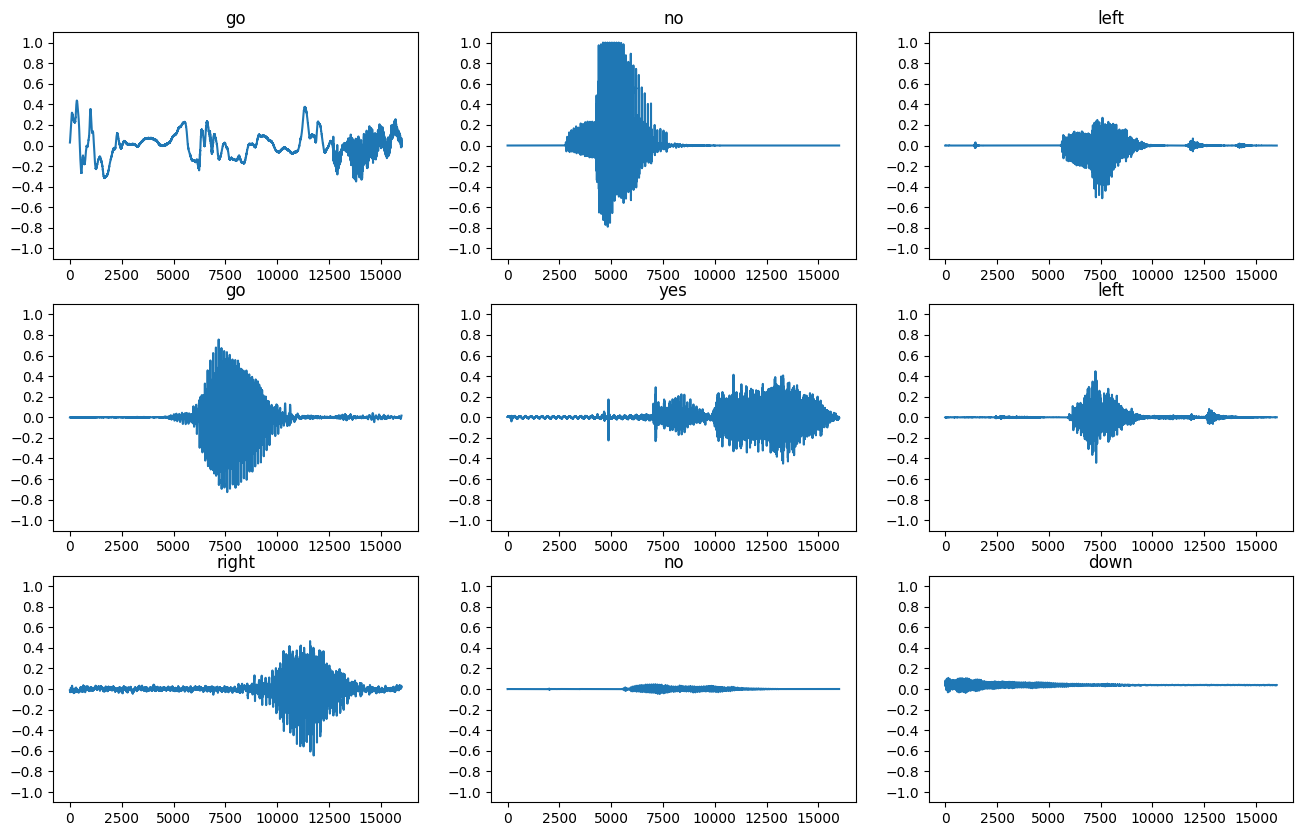

In [13]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## 2. Convert waveforms to spectrograms

### 2.1 Convert audio to plain (linear) spectrograms


The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

Note: here we are using the native tensorflow functions to do these transforms because they are faster and better integrated when you train a model in tensorflow. But normally it is common to use `librosa` for doing these things, which maybe easier to use.

In [14]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  #print('intermediate:',spectrogram.shape)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### 2.2 Convert to Mel-spectrograms

Mel scale is used to model human perception of pitch and frequencies by taking a log scale on linear Hertz values. To make a Mel-spectrogram, we first make (A) a plain spectrogram; (B) a set of Mel filters (matrixes). Then we just multiply the two to get Mel-spectrogram. Note that you can specify the number of Mel frequency bins to output. Common values are 40, 64, 128, etc., but they are typically smaller than the number of bins in the plain spectrograms. This is given by the `NUM_MEL` parameter.



In [15]:
NUM_FFT = 512
NUM_FREQS = 257
NUM_MEL = 40
SAMPLE_RATE = 16000
F_MIN = 0
F_MAX = 8000

In [16]:
# create the mel filters
lin_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=NUM_MEL,
            num_spectrogram_bins=NUM_FREQS,
            sample_rate=SAMPLE_RATE,
            lower_edge_hertz=F_MIN,
            upper_edge_hertz=F_MAX,
        )

In [17]:
def get_spectrogramMelTF(waveform, matrix=lin_to_mel_matrix):
    stfts = tf.signal.stft(
            waveform, frame_length=512, frame_step=256
        )
    mag_stfts = tf.abs(stfts)
    log_melspectrograms = tf.tensordot(mag_stfts, matrix, 1)
    mel_spectrogram = log_melspectrograms[..., tf.newaxis]
    return mel_spectrogram


### 2.3 Inspect some spectrograms and mel-spectrograms

In [18]:

for i in range(5):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  print("audio waveform shape:",waveform.shape)
  spectrogram = get_spectrogram(waveform)
  print("spectrogram shape:",spectrogram.shape)
print('\n')




audio waveform shape: (16000,)
spectrogram shape: (124, 129, 1)
audio waveform shape: (16000,)
spectrogram shape: (124, 129, 1)
audio waveform shape: (16000,)
spectrogram shape: (124, 129, 1)
audio waveform shape: (16000,)
spectrogram shape: (124, 129, 1)
audio waveform shape: (16000,)
spectrogram shape: (124, 129, 1)




In [19]:
# listen to the last audio clip above
display.display(display.Audio(waveform, rate=16000))

# Task 1: print out the shapes of 5 examples of mel-spectrograms like the spectrograms above. What do you see in their shapes? Why are they so different?

In [20]:
for i in range(5):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    print("audio waveform shape:",waveform.shape)
    mel_spec = get_spectrogramMelTF(waveform)
    print("Mel-spectrogram shape:",mel_spec.shape)
print('\n')

audio waveform shape: (16000,)
Mel-spectrogram shape: (61, 40, 1)
audio waveform shape: (16000,)
Mel-spectrogram shape: (61, 40, 1)
audio waveform shape: (16000,)
Mel-spectrogram shape: (61, 40, 1)
audio waveform shape: (16000,)
Mel-spectrogram shape: (61, 40, 1)
audio waveform shape: (16000,)
Mel-spectrogram shape: (61, 40, 1)




The waveform shape means that there are 16,000 amplitude samples in each waveform. This makes sense, because this is generally the resolution of speech audio. When converting to a spectogram, the audio gets split into overlapping frames that are small enough to take the FFT. In the spectogram shape of (124, 129, 1), the 124 corresponds to the number of frames. This is decided by the frame_length (255) and frame_step (128) decided in the spectogram function we defined. The 129 corresponds to the number of FFT frequency bins that the waveform might be split into for each frame, and the 1 is the number of channels -- which is 1 for audio.

The Mel spectogram has a different shape: (61, 40, 1). The channels here are the same, but the number of frames is significantly reduced. In addition, the FFT number is different, and that's because Mel-spectograms focus on frequencies that humans typically hear and speeck within. This allows you to keep the most relevant information while reducing the storage requirements.

### 2.4 plot some spectrograms

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

Now, define a function for displaying a spectrogram:

In [21]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  #log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  log_spec=spectrogram
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

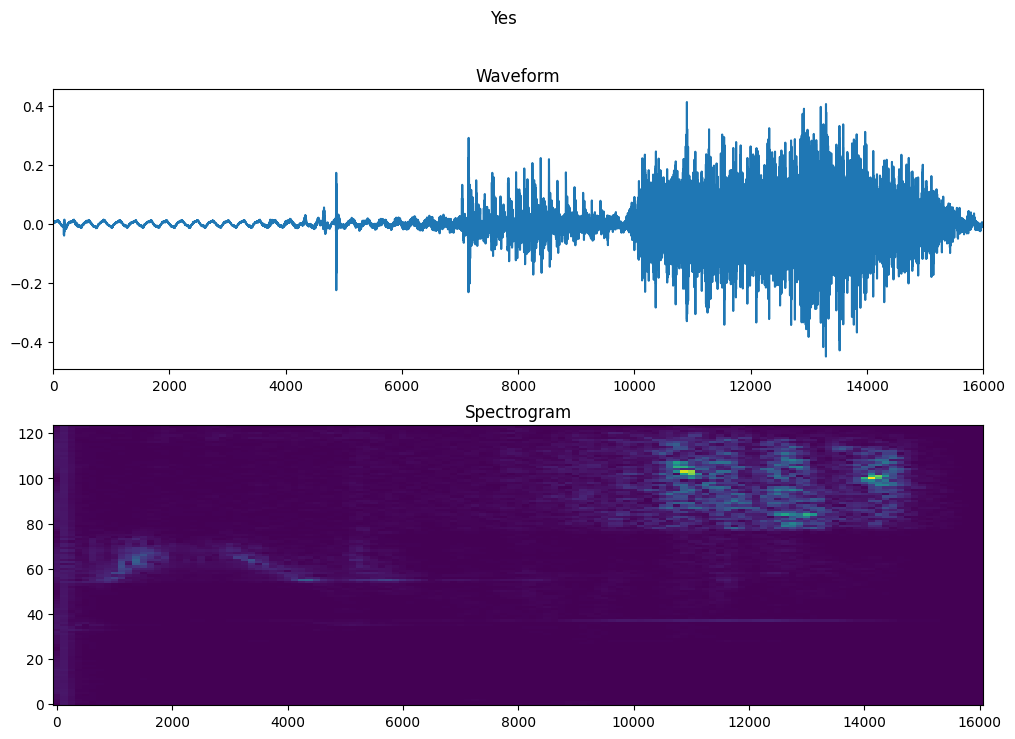

In [22]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

# Task 2: similar to above, plot the Mel-spectrogram for the same audio clip. What difference do you see?

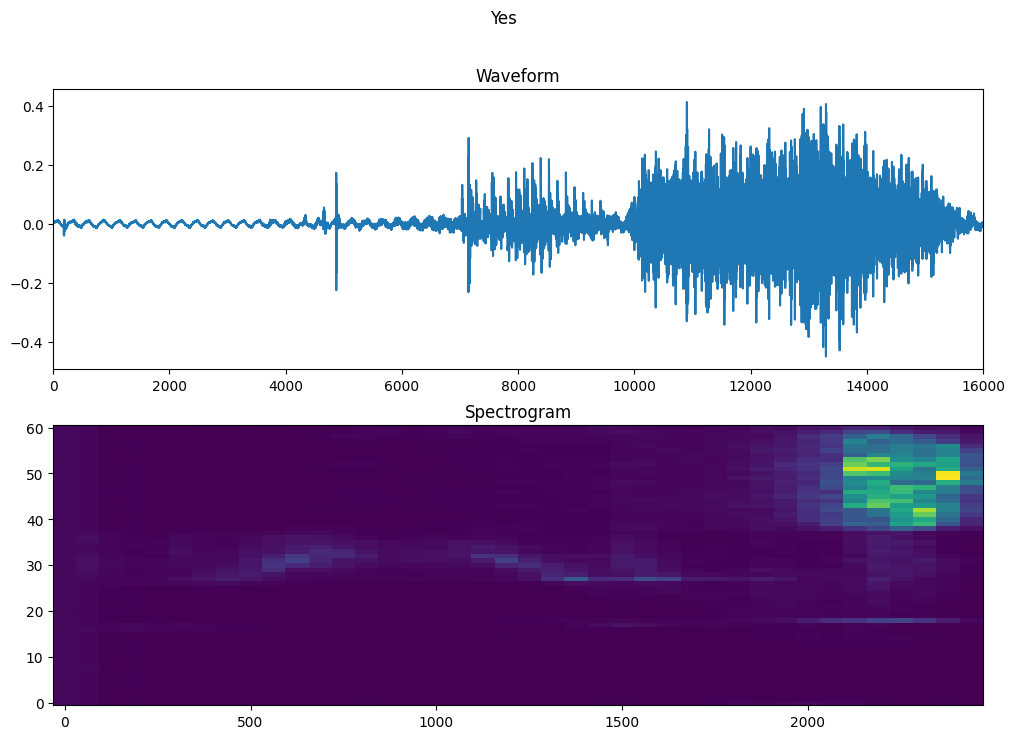

In [23]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(get_spectrogramMelTF(waveform), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

The Mel-Spectogram is on different x- and y-scales from the normal spectogram (frames and frequency bins, respectively). This corresponds to the difference in shapes we noted earlier. Nevertheless, they have pretty much the same pattern, but the Mel pattern has a lower resolution (more blocky) and it also takes up a larger portion of the overall frame.

### 2.5 Create spectrogram datasets from the audio datasets

In [24]:
def make_mel_spec_ds(ds, matrix=lin_to_mel_matrix):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogramMelTF(audio, matrix), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [27]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

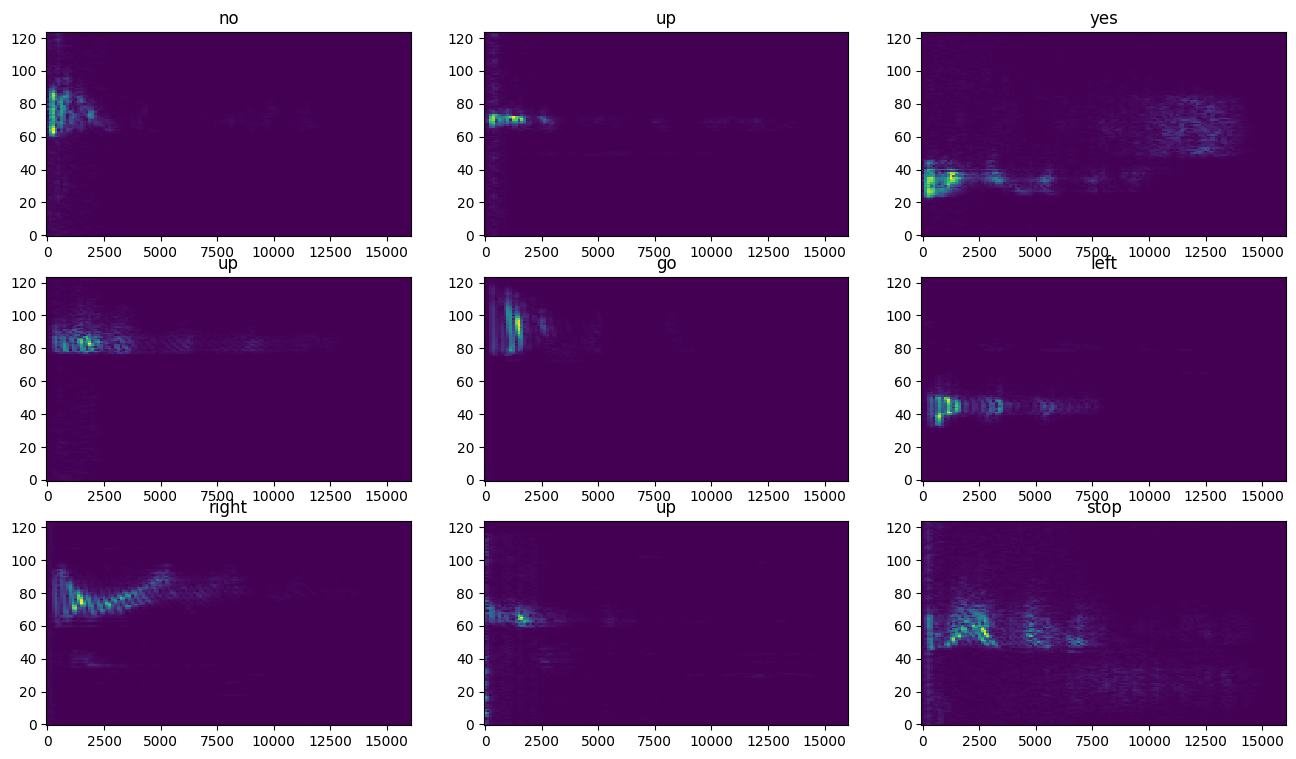

In [28]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Task 3: similar to 2.5 above, except that create the mel-spectrogram data sets and plot several examples.

In [29]:
train_mel_spectrogram_ds = make_mel_spec_ds(train_ds)
val_mel_spectrogram_ds = make_mel_spec_ds(val_ds)
test_mel_spectrogram_ds = make_mel_spec_ds(test_ds)

In [30]:
for example_spectrograms, example_spect_labels in train_mel_spectrogram_ds.take(1):
  break

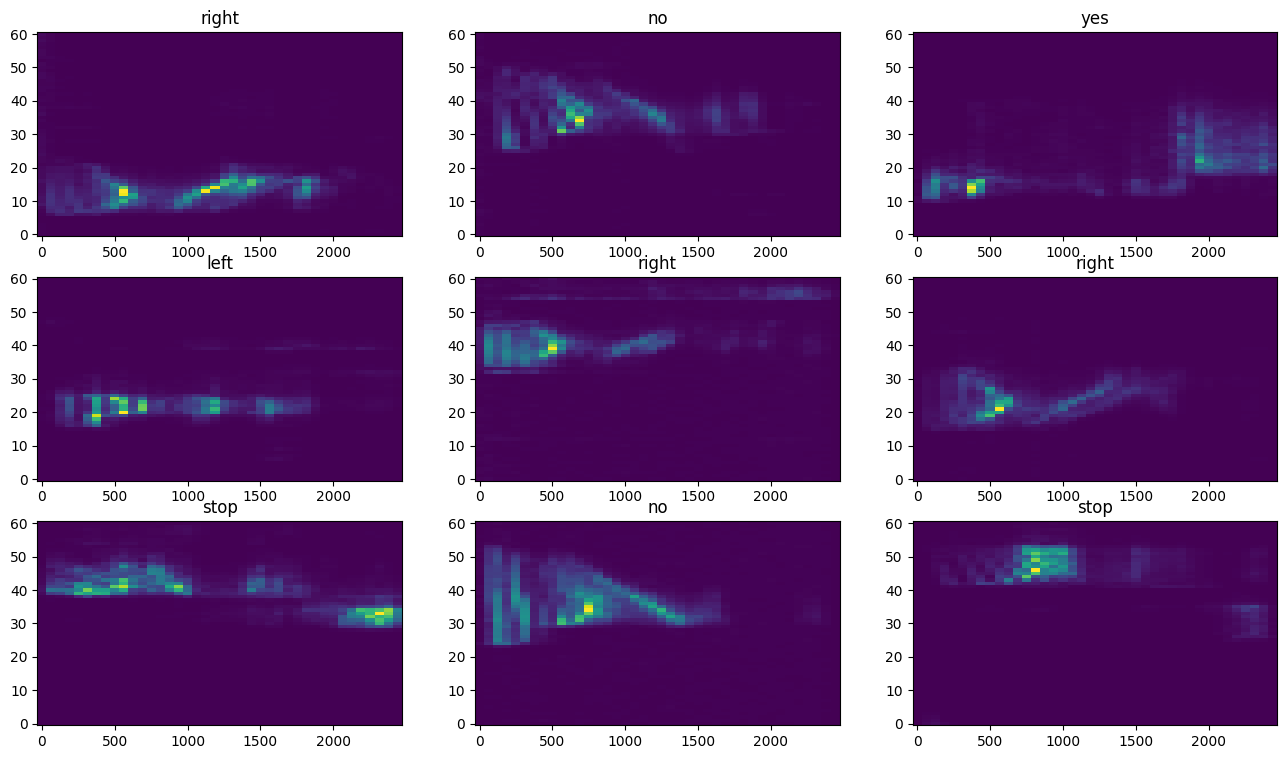

In [31]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

They basically just look like blown up versions of the vanilla spectograms.

## 3. Build and train the model

Now you should have two versions of the audio datasets: one dataset using spectrogram to represent the audio, the other dataset using mel-spectrogram. Let's train models on both of these data sets and see which one works better!

The following code examples all use the spectrogram datasets from above. To train on the mel-spectrogram dataset, you just need to run these commands on the mel-spectrogram dataset as input.

### 3.1 Train model using spectrogram

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [32]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [33]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (61, 40, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [35]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 214ms/step - accuracy: 0.2641 - loss: 1.9286 - val_accuracy: 0.6081 - val_loss: 1.2837
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.5531 - loss: 1.2678 - val_accuracy: 0.6888 - val_loss: 0.9633
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.6591 - loss: 0.9590 - val_accuracy: 0.7253 - val_loss: 0.8024
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.7180 - loss: 0.7846 - val_accuracy: 0.7904 - val_loss: 0.7164
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.7649 - loss: 0.6631 - val_accuracy: 0.7943 - val_loss: 0.6590
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.7993 - loss: 0.5581 - val_accuracy: 0.8190 - val_loss: 0.5787
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.8163 - loss: 0.5128 - val_accuracy: 0.8216 - val_loss: 0.5546
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.8432 - loss: 0

Let's plot the training and validation loss curves to check how your model has improved during training:

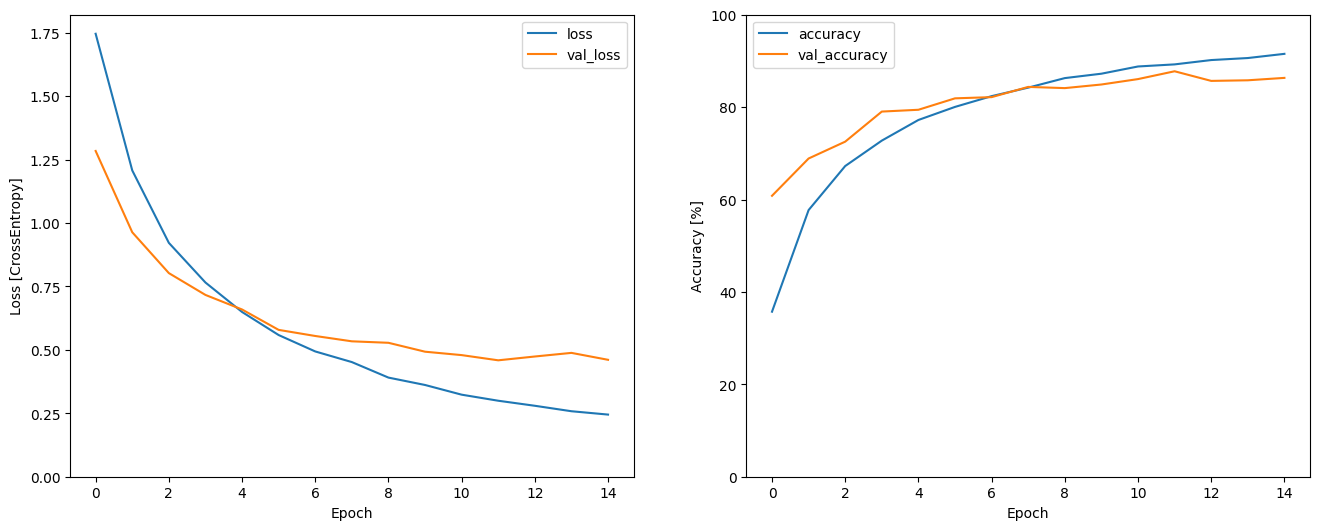

In [36]:
def plot_train_val_loss(history):
    metrics = history.history
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1,2,2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')

plot_train_val_loss(history)

It looks the model is overfitting a bit, because the training loss decreases while the validation loss plateaus. Similarly, the training accuracy continues increasing while the validation accuracy wobbles around the same values.

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [37]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.8394 - loss: 0.4496


{'accuracy': 0.8497596383094788, 'loss': 0.4625351130962372}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [38]:
y_pred = model.predict(test_spectrogram_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [39]:
y_pred = tf.argmax(y_pred, axis=1)

In [40]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

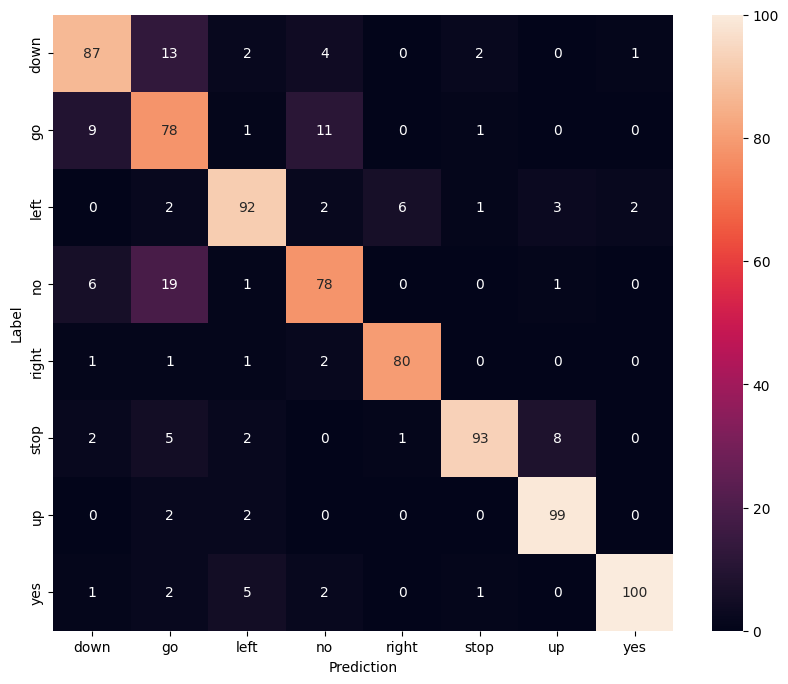

In [41]:
def plot_confusion_matrix(y_true, y_pred):
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=label_names,
                yticklabels=label_names,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

plot_confusion_matrix(y_true, y_pred)

Good news: this shows a strong correlation between correct answers.

### 3.2 Train model on Mel spectrogram

Now it is your turn to train model on mel-spectrogram input.

# Task 4: Train model using Mel-spectrogram

Train models and eveluate then using the above code but just using the mel-spectrogram dataset instead of the spectrogram dataset. Report back the comparison between the two models.

Extra credit (worth 20% of this homework): Try using NUM_MEL=128 and see if that affects the performance of the mel-spectrogram.

In [42]:
def train_new_model(train, val, test):
    # reduce latency while training the mel model
    train_spectrogram_ds = train.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
    val_spectrogram_ds = val.cache().prefetch(tf.data.AUTOTUNE)
    test_spectrogram_ds = test.cache().prefetch(tf.data.AUTOTUNE)

    # use simple CNN to analyze mel spectogram images
    input_shape = example_spectrograms.shape[1:]
    print('Input shape:', input_shape)
    num_labels = len(label_names)

    # Instantiate the `tf.keras.layers.Normalization` layer.
    norm_layer = layers.Normalization()
    # Fit the state of the layer to the spectrograms
    # with `Normalization.adapt`.
    norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Downsample the input.
        layers.Resizing(32, 32),
        # Normalize.
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ])

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    # train on 20 epochs with early stopping implemented
    EPOCHS = 20
    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=EPOCHS,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
    )

    return model, history

In [43]:
mel_40_model, mel_40_history = train_new_model(
    train_mel_spectrogram_ds,
    val_mel_spectrogram_ds,
    test_mel_spectrogram_ds)

Input shape: (61, 40, 1)
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - accuracy: 0.3263 - loss: 1.8428 - val_accuracy: 0.7096 - val_loss: 0.9767
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.6620 - loss: 1.0024 - val_accuracy: 0.8229 - val_loss: 0.6457
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.7586 - loss: 0.6944 - val_accuracy: 0.8568 - val_loss: 0.5099
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.8236 - loss: 0.5297 - val_accuracy: 0.8919 - val_loss: 0.4152
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - accuracy: 0.8634 - loss: 0.4166 - val_accuracy: 0.8789 - val_loss: 0.4048
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 206ms/step - accuracy: 0.8794 - loss: 0.3467 - val_accuracy: 0.8893 - val_loss: 0.3660
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.8924 - loss: 0.3022 - val_accuracy: 0.8971 - val_loss: 0.3545
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - a

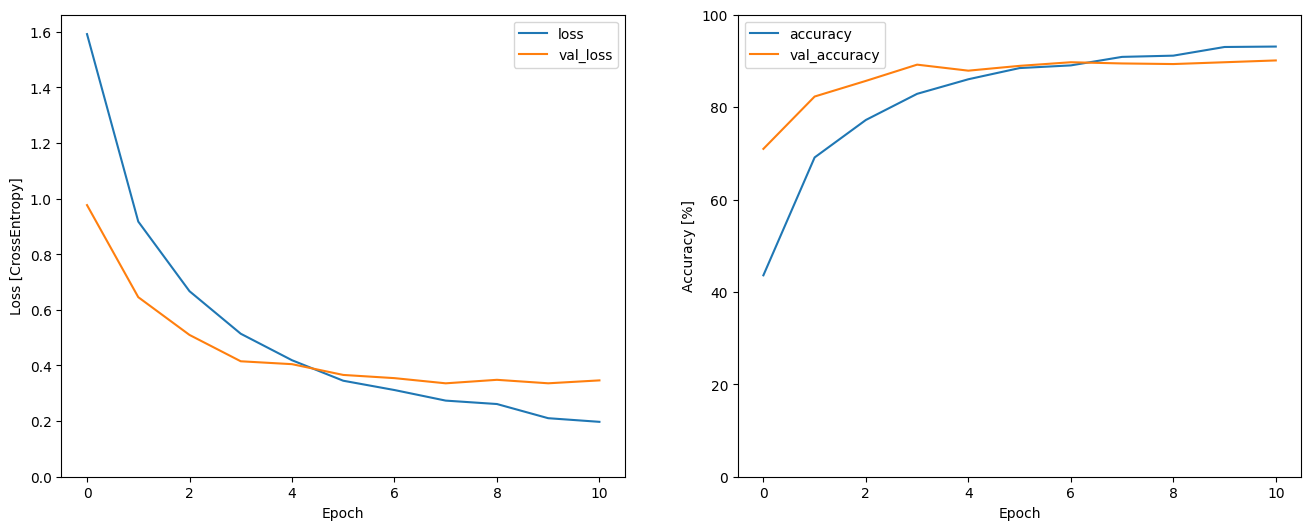

In [44]:
# plot training and validation loss curves
plot_train_val_loss(mel_40_history)

In [45]:
# discover the predictions of this mel model
mel_40_model.evaluate(test_mel_spectrogram_ds, return_dict=True)
mel_40_y_pred = mel_40_model.predict(test_mel_spectrogram_ds)
mel_40_y_pred = tf.argmax(mel_40_y_pred, axis=1)
mel_40_y_true = tf.concat(list(test_mel_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8860 - loss: 0.3708
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


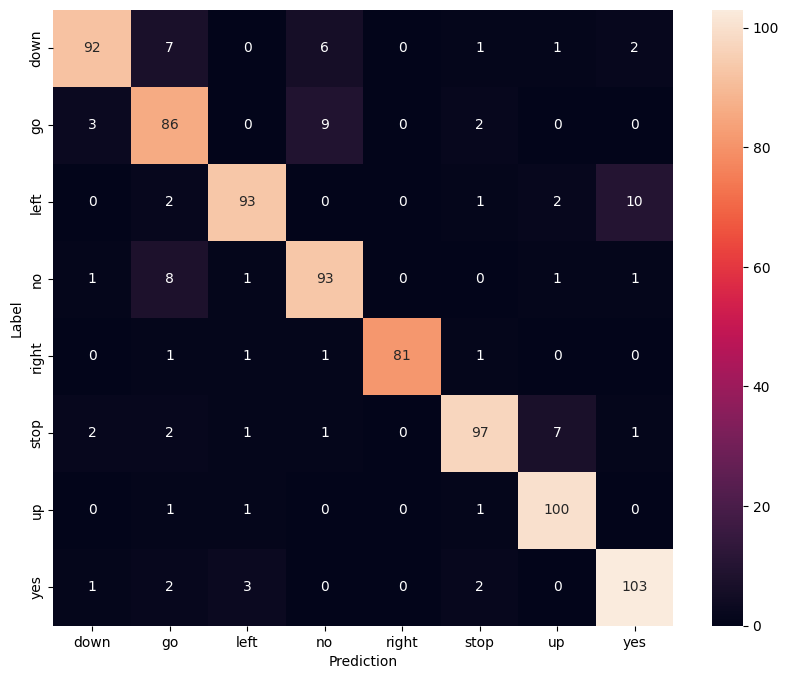

In [46]:
# visualize the confusion matrix
plot_confusion_matrix(mel_40_y_true, mel_40_y_pred)

The vanilla model had about 86% validation / 85% test accuracy, whereas this model is repporting 89% validation / 87% test accuracy. I am slightly surprised that the data crompression produced better results. I think it is explained by the fact that the original model was overfitting on training signatures. While this model still shows some evidence of overfitting particularly between the loss of train vs. validation, the accuracies are much closer to one another.

## 4. Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

Vanilla predicted: no
Mel_40 predicted: no


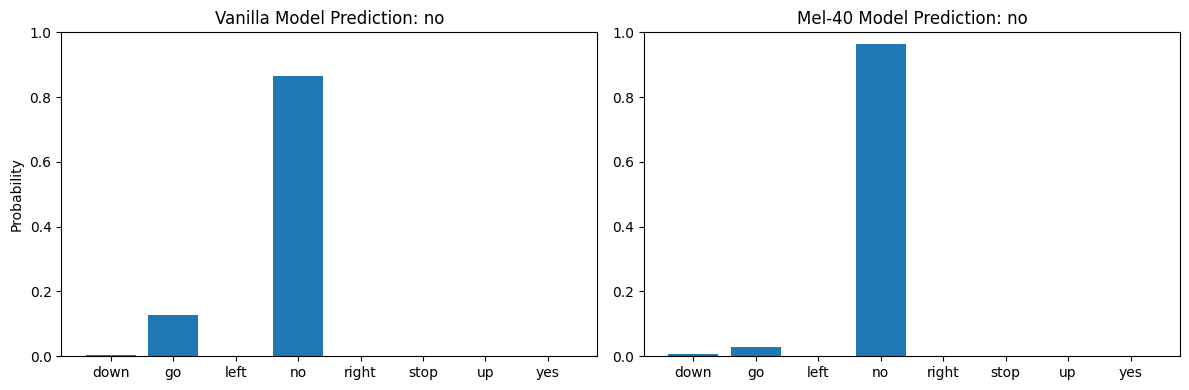

In [47]:
# load and preprocess audio file
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)

# save the waveform to play later
waveform = x

# get both spectograms
vanilla_x = get_spectrogram(x)[tf.newaxis,...]
mel_40_x = get_spectrogramMelTF(x)[tf.newaxis,...]

# make rpedictions
vanilla_prediction = model(vanilla_x)
mel_40_prediction = mel_40_model(mel_40_x)
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

vanilla_predicted_label = x_labels[tf.argmax(vanilla_prediction[0])]
mel_40_predicted_label = x_labels[tf.argmax(mel_40_prediction[0])]
print(f"Vanilla predicted: {vanilla_predicted_label}")
print(f"Mel_40 predicted: {mel_40_predicted_label}")

# plot side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Vanilla
axs[0].bar(x_labels, tf.nn.softmax(vanilla_prediction[0]))
axs[0].set_title(f'Vanilla Model Prediction: {vanilla_predicted_label}')
axs[0].set_ylim([0, 1])
axs[0].set_ylabel('Probability')

# Mel-40
axs[1].bar(x_labels, tf.nn.softmax(mel_40_prediction[0]))
axs[1].set_title(f'Mel-40 Model Prediction: {mel_40_predicted_label}')
axs[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# display the audio
display.display(display.Audio(waveform, rate=16000))

As the output suggests, both models correctly recognized this audio as "no". Interestingly, the vanilla model seems to have a slightly higher prob for "go" than the mel_40 model.

**Now I will try 64 and 128 values for NUM_MEL.**

In [48]:
def create_filters(NUM_MEL):
    matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=NUM_MEL,
            num_spectrogram_bins=NUM_FREQS,
            sample_rate=SAMPLE_RATE,
            lower_edge_hertz=F_MIN,
            upper_edge_hertz=F_MAX,
        )
    return matrix

In [49]:
# create filter with 64 Mel-frequency bins
lm_mat = create_filters(64)
train_mel_64 = make_mel_spec_ds(train_ds, lm_mat)
val_mel_64 = make_mel_spec_ds(val_ds, lm_mat)
test_mel_64 = make_mel_spec_ds(test_ds, lm_mat)

In [50]:
# train the 64-model
mel_64_model, mel_64_hist = train_new_model(train_mel_64, val_mel_64, test_mel_64)

Input shape: (61, 40, 1)
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 294ms/step - accuracy: 0.3190 - loss: 1.8633 - val_accuracy: 0.6953 - val_loss: 1.0168
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.6601 - loss: 1.0117 - val_accuracy: 0.8125 - val_loss: 0.6508
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 233ms/step - accuracy: 0.7844 - loss: 0.6598 - val_accuracy: 0.8516 - val_loss: 0.5029
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.8289 - loss: 0.5154 - val_accuracy: 0.8659 - val_loss: 0.4272
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 287ms/step - accuracy: 0.8699 - loss: 0.4024 - val_accuracy: 0.8789 - val_loss: 0.4006
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 253ms/step - accuracy: 0.8774 - loss: 0.3593 - val_accuracy: 0.8906 - val_loss: 0.3545
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.8987 - loss: 0.3009 - val_accuracy: 0.8906 - val_loss: 0.3497
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - a

In [51]:
# discover the predictions of this mel model
mel_64_model.evaluate(test_mel_64, return_dict=True)
mel_64_y_pred = mel_64_model.predict(test_mel_64)
mel_64_y_pred = tf.argmax(mel_64_y_pred, axis=1)
mel_64_y_true = tf.concat(list(test_mel_64.map(lambda s,lab: lab)), axis=0)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8782 - loss: 0.4767
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


In [52]:
# create filter with 18 Mel-frequency bins
lm_mat_128 = create_filters(128)
train_mel_128 = make_mel_spec_ds(train_ds, lm_mat_128)
val_mel_128 = make_mel_spec_ds(val_ds, lm_mat_128)
test_mel_128 = make_mel_spec_ds(test_ds, lm_mat_128)

# train the 64-model
mel_128_model, mel_128_hist = train_new_model(train_mel_128, val_mel_128, test_mel_128)

# discover the predictions of this mel model
mel_128_model.evaluate(test_mel_128, return_dict=True)
mel_128_y_pred = mel_128_model.predict(test_mel_128)
mel_128_y_pred = tf.argmax(mel_128_y_pred, axis=1)
mel_128_y_true = tf.concat(list(test_mel_128.map(lambda s,lab: lab)), axis=0)

Input shape: (61, 40, 1)
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.2947 - loss: 1.8952 - val_accuracy: 0.6589 - val_loss: 1.1257
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.6258 - loss: 1.1108 - val_accuracy: 0.7604 - val_loss: 0.7325
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.7523 - loss: 0.7413 - val_accuracy: 0.8021 - val_loss: 0.5878
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.7977 - loss: 0.5818 - val_accuracy: 0.8568 - val_loss: 0.4731
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.8425 - loss: 0.4657 - val_accuracy: 0.8516 - val_loss: 0.4448
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.8532 - loss: 0.4055 - val_accuracy: 0.8555 - val_loss: 0.4168
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.8838 - loss: 0.3274 - val_accuracy: 0.8698 - val_loss: 0.3964
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - a

**Final Results**

| Model         | Test Accuracy (%)| Loss     |
|---------------|--------------|----------|
| Vanilla       | 83.9         | 0.44     |
| Mel-40        | 88.6         | 0.37     |
| Mel-64.       | 87.8         | 0.47     |
| Mel-128       | 87.9         | 0.40     |


# Task 5: Test both models on 3 randomly sampled commands from the data folders. Did they get it right?

In [59]:
import random

# get 2 random samples from the data folders
all_files = list(data_dir.rglob("*.wav"))
sampled_files = random.sample(all_files, 3)

# define the models
models = [model, mel_40_model, mel_64_model, mel_128_model]
model_names = ['Vanilla', 'Mel-40', 'Mel-64', 'Mel-128']

print(sampled_files)

[PosixPath('data/mini_speech_commands_extracted/mini_speech_commands/left/7ea032f3_nohash_2.wav'), PosixPath('data/mini_speech_commands_extracted/mini_speech_commands/yes/1ed557b9_nohash_0.wav'), PosixPath('data/mini_speech_commands_extracted/mini_speech_commands/right/4620dc14_nohash_0.wav')]


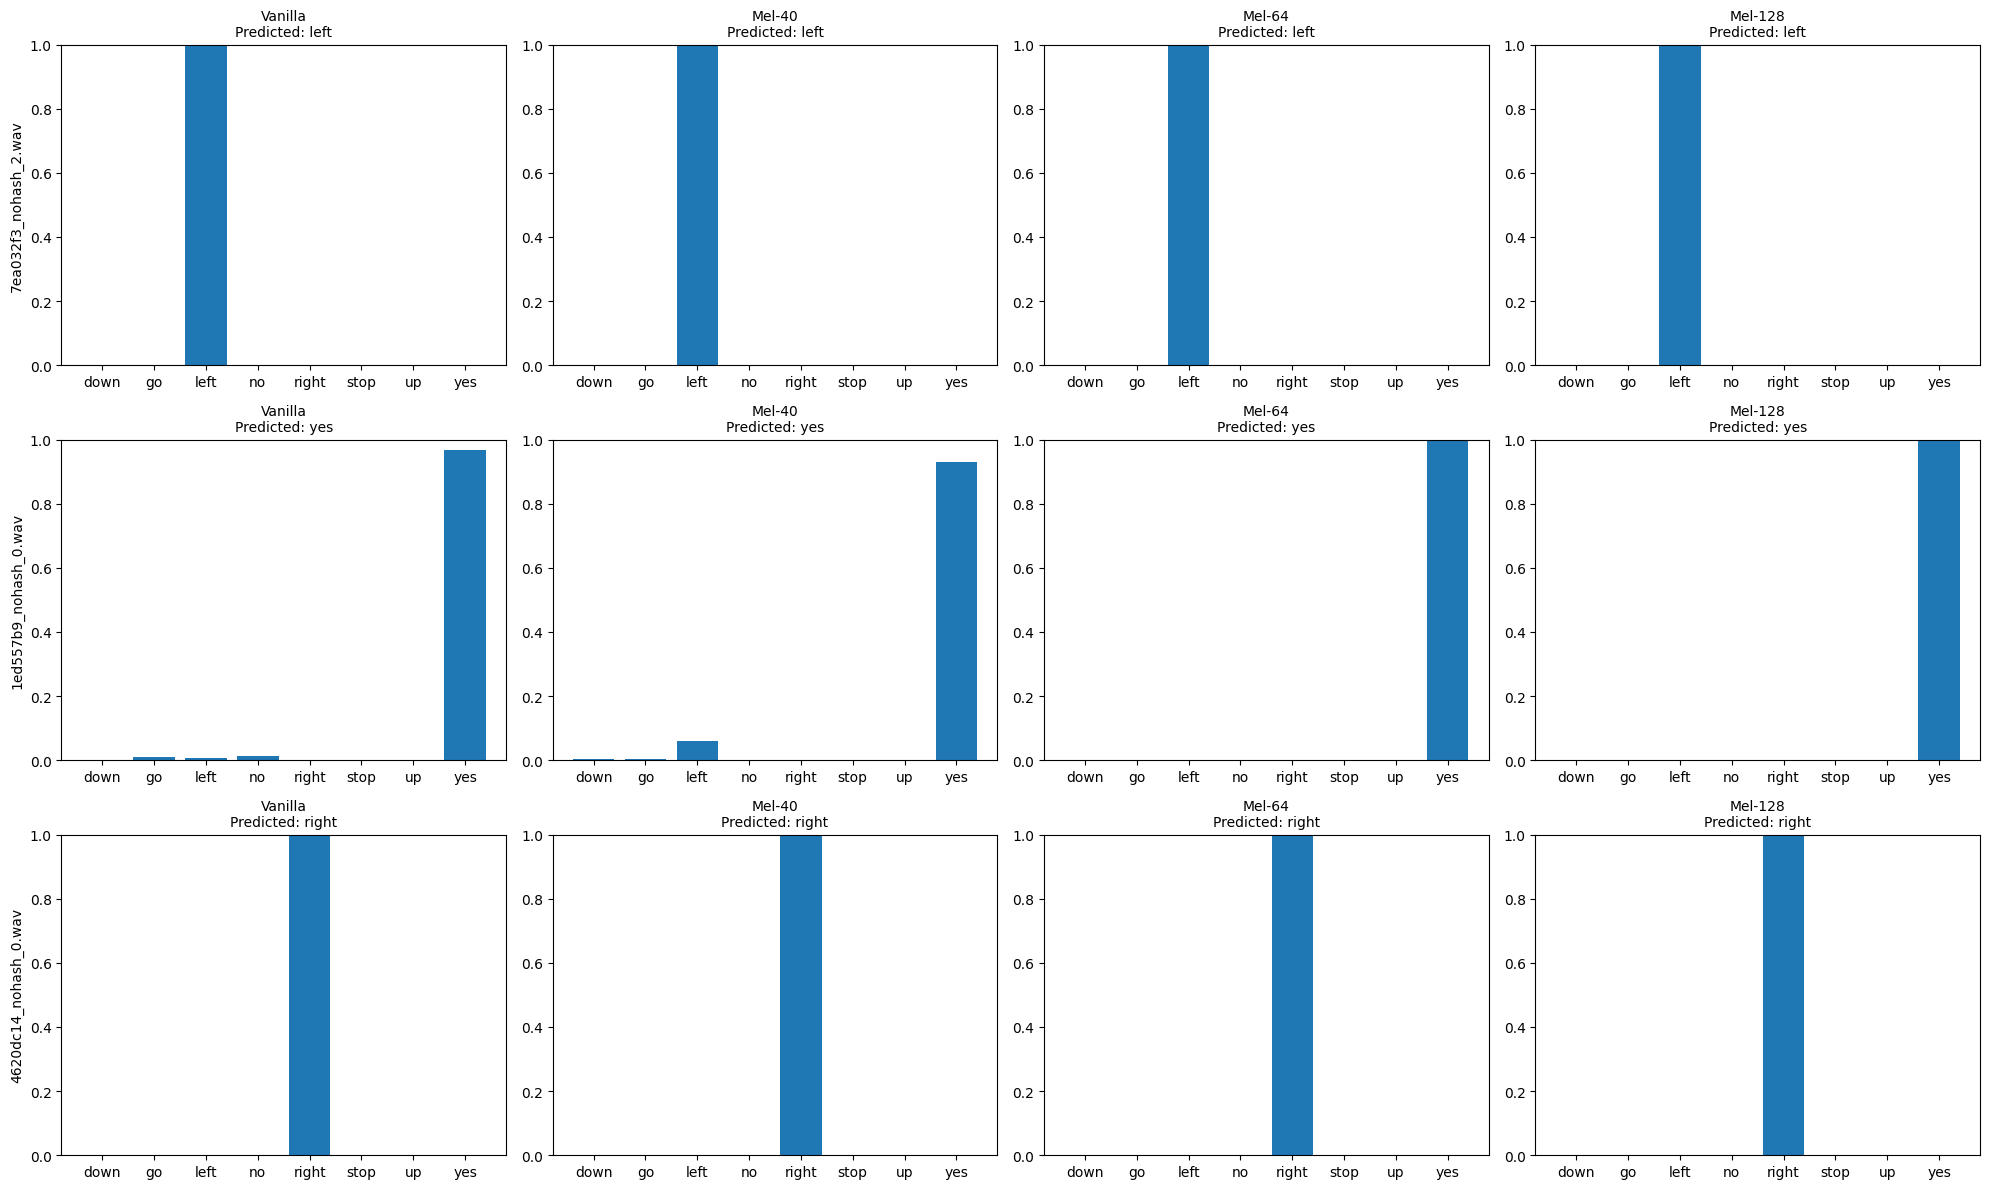

In [62]:
def compare_models_on_samples(sampled_files, models, model_names, x_labels):

    num_samples = len(sampled_files)
    fig, axs = plt.subplots(num_samples, len(models), figsize=(5 * len(models), 4 * num_samples))

    # load and process each audio sample
    for i, file_path in enumerate(sampled_files):
        audio = tf.io.read_file(str(file_path))
        waveform, _ = tf.audio.decode_wav(audio, desired_channels=1, desired_samples=16000)
        waveform = tf.squeeze(waveform, axis=-1)

        # ugly code to get the right spectrogram depending on model
        for j, model in enumerate(models):
            if "Vanilla" in model_names[j]:
                input_spec = get_spectrogram(waveform)

            elif "Mel-40" in model_names[j]:
                matrix = tf.signal.linear_to_mel_weight_matrix(
                    num_mel_bins=40,
                    num_spectrogram_bins=NUM_FREQS,
                    sample_rate=SAMPLE_RATE,
                    lower_edge_hertz=F_MIN,
                    upper_edge_hertz=F_MAX,)
                input_spec = get_spectrogramMelTF(waveform, matrix)

            elif "Mel-64" in model_names[j]:
                lin_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
                    num_mel_bins=64,
                    num_spectrogram_bins=NUM_FREQS,
                    sample_rate=SAMPLE_RATE,
                    lower_edge_hertz=F_MIN,
                    upper_edge_hertz=F_MAX,)
                input_spec = get_spectrogramMelTF(waveform, matrix)

            elif "Mel-128" in model_names[j]:
                lin_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
                    num_mel_bins=128,
                    num_spectrogram_bins=NUM_FREQS,
                    sample_rate=SAMPLE_RATE,
                    lower_edge_hertz=F_MIN,
                    upper_edge_hertz=F_MAX,)
                input_spec = get_spectrogramMelTF(waveform, matrix)
            else:
                raise ValueError(f"Unknown model type: {model_names[j]}")
            spec = input_spec[tf.newaxis, ...]

            # make this prediction
            prediction = model(spec)
            probs = tf.nn.softmax(prediction[0]).numpy()
            predicted_label = x_labels[np.argmax(probs)]
            ax = axs[i, j] if num_samples > 1 else axs[j]

            ax.bar(x_labels, probs)
            ax.set_ylim([0, 1])
            ax.set_title(f"{model_names[j]}\nPredicted: {predicted_label}", fontsize=10)
            if j == 0:
                ax.set_ylabel(file_path.name)

    plt.tight_layout()
    plt.show()

compare_models_on_samples(sampled_files, models, model_names, x_labels)

They all look to be performing pretty well. This correspond with the accuracy and loss result I was seeing earlier. I am surprised they are so similar, but happy to see these graphs to affirm that they are not exactly the same.

# Optional sections: Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.